## Exploring NEON (National Ecological Observatory Network) AOP (Airborne Operations Platform) and NEON BioRepository Data Together

##### In this project, we will be looking at NEON AOP data for 2016 and 2017 in the GRSM (Great Smokey Mountains) Domain. Between the 2016 and 2017 collection of data, a large fire occurred in the domain leaving a prominent burn scar. We will be using the GEE (Google Earth Engine) API to explore the burn scar using the NBR (Normalize Burn Ratio) to set a threshold to identify burnt areas. We will then us the PyGBIF API (Python Global Biodiversity Information Facility) to pull records from the NEON BioRepository to see if and/or how Carabid beetle traps in the domain were impacted by the fires.

## Part 1: Pulling + Visualizing Imagery and Occurence Records via APIs

#### Step 1: Import and authenticate GEE and geemap with your username and project

In [38]:
import ee
import geemap

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="ee-krle4401")

#### Step 2: Pull NEON Imagery from GEE

In [ ]:
# Define an area of interest, for the imagery, I will simply be using a centroid because I want all
# the imagery from GRSM domain. You can using a bounding box, shapefiles, etc. if you want a more granular
# control of the geographic area
site_center = ee.Geometry.Point([-83.5, 35.7])

# Load Hyperspectral AOP Image Collection
sdr_col = ee.ImageCollection('projects/neon-prod-earthengine/assets/HSI_REFL/001')

# Retrieve all available image IDs to make a list if you want to see everything, but also to cross 
# reference years you may want
image_ids = sdr_col.aggregate_array("system:index").getInfo()
print("Available AOP Image IDs:", image_ids)

# Define a function that allows you to look through multiple years and domains of image collections
def filter_aop_images(years, domains):
    """
    Filters the AOP image collection based on a list of years and domains.
    
    Parameters:
        years (list): List of years (e.g., ["2016", "2017"]).
        domains (list): List of 4-letter site codes (e.g., ["GRSM", "HARV"]).
    
    Returns:
        Dictionary with (year, domain) as key and list of matching image IDs.
    """
    filtered_results = {}

    for year in years:
        for domain in domains:
            matching_ids = [img_id for img_id in image_ids if year in img_id and domain in img_id]
            if matching_ids:
                filtered_results[(year, domain)] = matching_ids

    return filtered_results

# Define years and domains that you want to look at (NOTE: this code can be used from multiple years
# and domains)
years_input = ["2016", "2017"]  # Add multiple years here
domains_input = ["GRSM"]  # Add multiple domains here

# Get image filtered by year and domain
filtered_images = filter_aop_images(years_input, domains_input)

# NEON does not fly every single domain every year so there may be years where imagery is unavailable
# I like to have a conditional statement so I can easily check if there are no images available, but 
# also print a list in case only some years are available
if not filtered_images:
    print(f"No AOP images found for the selected years and domains.")
else:
    print(f"Found AOP images: {filtered_images}")


Available AOP Image IDs: ['2013_CPER_1', '2014_HARV_2', '2014_JERC_1', '2015_MLBS_1', '2015_TALL_1', '2016_CLBJ_1', '2016_GRSM_2', '2016_HARV_3', '2016_JERC_2', '2016_SERC_1', '2016_TALL_2', '2017_CLBJ_2', '2017_CPER_3', '2017_GRSM_3', '2017_HARV_4', '2017_JERC_3', '2017_MLBS_2', '2017_OAES_2', '2017_SERC_3', '2017_SRER_1', '2017_TALL_3', '2018_GUAN_1', '2018_HARV_5', '2018_JERC_4', '2018_MCRA_1', '2018_MLBS_3', '2018_OAES_3', '2018_SRER_2', '2018_TALL_4', '2019_CLBJ_4', '2019_HARV_6', '2019_HEAL_3', '2019_JERC_5', '2019_JORN_3', '2019_NIWO_3', '2019_OAES_4', '2019_SERC_4', '2019_SOAP_4', '2019_SRER_3', '2019_TALL_5', '2020_CPER_5', '2020_CPER_7', '2020_NIWO_4', '2020_RMNP_3', '2020_YELL_3', '2021_ABBY_4', '2021_BONA_4', '2021_CLBJ_5', '2021_CPER_8', '2021_HEAL_4', '2021_JERC_6', '2021_JORN_4', '2021_MCRA_2', '2021_OAES_5', '2021_OSBS_6', '2021_SERC_5', '2021_SJER_5', '2021_SOAP_5', '2021_SRER_4', '2021_TALL_6']
Found AOP images: {('2016', 'GRSM'): ['2016_GRSM_2'], ('2017', 'GRSM'): ['

#### Step 2: Calculate NBR (Normalized Burn Ratio) and visualize for 2016 and 2017 imagery

In [32]:
# NBR Visualization Parameters
nbr_vis_params = {
    'min': -1, 'max': 1,
    'palette': ['white', 'yellow', 'red', 'black']  # typical burn severity color ramp
}

# Function to Compute NBR
def addNBRBands(image):
    nbr = image.normalizedDifference(['B097', 'B220']).rename('NBR')
    return image.addBands(nbr).set({'Sensor': 'AOP'})

# Create a geemap Map instance for NBR visualization
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Loop through filtered images and compute NBR
for (year, domain), image_ids in filtered_images.items():
    for image_id in image_ids:
        # Retrieve the image by its system:index
        aop_image = sdr_col.filter(ee.Filter.eq("system:index", image_id)).first()

        # Compute NBR
        if aop_image:
            aop_nbr = addNBRBands(aop_image).select('NBR')
            print(f"NBR computed for AOP image: {image_id}")

            # Add layer with proper naming
            NBR_Map.addLayer(aop_nbr, nbr_vis_params, f'AOP NBR ({image_id})')

# Save the final interactive HTML map for NBR
html_nbr_filename = f"AOP_NBR_{'_'.join(years_input)}_{'_'.join(domains_input)}.html"
NBR_Map.to_html(filename=html_nbr_filename)

print(f"NBR visualization saved: {html_nbr_filename}")

NBR computed for AOP image: 2016_GRSM_2
NBR computed for AOP image: 2017_GRSM_3
NBR visualization saved: AOP_NBR_2016_2017_GRSM.html


#### Import the Python GBIF API with necessary packages for geometry and data analysis

In [33]:
from pygbif import occurrences as gbif_occ
import geopandas as gpd
from shapely.geometry import Polygon
import pandas as pd

# GSMNP centroid and bounding box parameters
latitude, longitude = 35.6118, -83.4895
bbox_size_deg = 0.09  # Approx. 10 km (~0.09 degrees)

# Create bounding box polygon
bounding_box_coords = [
    (longitude - bbox_size_deg, latitude - bbox_size_deg),  # Bottom-left
    (longitude + bbox_size_deg, latitude - bbox_size_deg),  # Bottom-right
    (longitude + bbox_size_deg, latitude + bbox_size_deg),  # Top-right
    (longitude - bbox_size_deg, latitude + bbox_size_deg),  # Top-left
    (longitude - bbox_size_deg, latitude - bbox_size_deg)   # Close polygon
]
bounding_polygon = Polygon(bounding_box_coords)
polygon_wkt = bounding_polygon.wkt

# Get carabid records
carabid_records = []
carabid_taxon_key = 3792  # <-- update with correct taxon key for Carabidae
for year in [2016, 2017]:
    occurrences = gbif_occ.search(
        taxonKey=carabid_taxon_key,
        geometry=polygon_wkt,
        year=year,
        hasCoordinate=True,
        limit=300
    )
    prefix = f"grsm.{year}".lower()
    for occ in occurrences.get("results", []):
        if "eventID" in occ and occ["eventID"].lower().startswith(prefix):
            try:
                lat = float(occ["decimalLatitude"])
                lon = float(occ["decimalLongitude"])
                carabid_records.append({
                    "species": occ.get("species", "Unknown"),
                    "latitude": lat,
                    "longitude": lon,
                    "year": year,
                    "eventID": occ.get("eventID")
                })
            except (KeyError, TypeError, ValueError):
                continue

# Convert carabid records to GeoDataFrame and export as GeoJSON and CSV
carabid_gdf = gpd.GeoDataFrame(
    carabid_records,
    geometry=gpd.points_from_xy(
        [r['longitude'] for r in carabid_records],
        [r['latitude'] for r in carabid_records]
    ),
    crs="EPSG:4326"
)
carabid_gdf.to_file("gbif_carabids_gsmnp_2016_2017.geojson", driver="GeoJSON")
carabid_gdf.drop(columns='geometry').to_csv("gbif_carabids_gsmnp_2016_2017.csv", index=False)


INFO:Created 416 records


#### Visualize AOP Imagery and GBIF records together

In [34]:
# Load GBIF records from the GeoJSON file
gbif_geojson = "gbif_carabids_gsmnp_2016_2017.geojson"
carabid_gdf = gpd.read_file(gbif_geojson)

# Separate the GBIF records by year
carabid_2016 = carabid_gdf[carabid_gdf["year"] == 2016]
carabid_2017 = carabid_gdf[carabid_gdf["year"] == 2017]

# Add the GBIF points to the map as separate layers
NBR_Map.add_gdf(carabid_2016, layer_name="GBIF NEON Carabidae Trap Records 2016")
NBR_Map.add_gdf(carabid_2017, layer_name="GBIF NEON Carabidae Trap Records 2017")

# (Optional) Save the interactive NBR_map to an HTML file
output_html = "Combined_NBR_GBIF_NBR_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Combined map saved as: {output_html}")

Combined map saved as: Combined_NBR_GBIF_NBR_Map.html


## Part 2: Digging a little deeper with Analysis

In [39]:


# --- STEP 1: Select pre-fire and post-fire images ---
# Assuming filtered_images is a dictionary with keys like ('2016', 'GRSM') and ('2017', 'GRSM')
# Here we simply choose the first image ID for each year.
pre_fire_img_id = filtered_images.get(('2016', 'GRSM'))[0]
post_fire_img_id = filtered_images.get(('2017', 'GRSM'))[0]

# Retrieve the images from the collection
pre_fire_image = sdr_col.filter(ee.Filter.eq("system:index", pre_fire_img_id)).first()
post_fire_image = sdr_col.filter(ee.Filter.eq("system:index", post_fire_img_id)).first()

# --- STEP 2: Compute NBR for each image using your function ---
pre_fire_nbr = addNBRBands(pre_fire_image).select('NBR')
post_fire_nbr = addNBRBands(post_fire_image).select('NBR')

# --- STEP 3: Calculate dNBR (difference NBR) ---
dnbr = pre_fire_nbr.subtract(post_fire_nbr).rename('dNBR')

# --- STEP 4: Apply a threshold to classify burned areas ---
# Example: mark pixels as burned if dNBR > 0.27 (indicative of moderate to high burn severity)
burn_threshold = 0.27  # This value may be adjusted based on local calibration or sensor characteristics.
burned_area_mask = dnbr.gt(burn_threshold)

# Optional: visualize burned vs unburned areas using a simple palette.
dnbr_viz_params = {
    'min': 0,
    'max': 1,
    'palette': ['white', 'orange', 'red']
}

# --- STEP 5: Vectorize the Burn Scar Mask ---
# Define a region of interest (ROI) for vectorization.
# You might base this on an extent around your site_center; here we buffer the center by 5000m.
roi = site_center.buffer(5000)

# Convert the burned area mask into vectors (polygons)
burn_vectors = burned_area_mask.selfMask().reduceToVectors(
    geometry=roi,
    crs=post_fire_image.projection(), 
    scale=10,  # Adjust scale (pixel size) as appropriate for the data.
    geometryType='polygon',
    labelProperty='burned',
    reducer=ee.Reducer.countEvery()
)

# --- STEP 6: Visualize the dNBR, burned area, and vectorized burn scar on the map ---
# Create a geemap Map instance (if not already created)
NBR_Map = geemap.Map()
NBR_Map.centerObject(site_center, 11)

# Add dNBR layer
NBR_Map.addLayer(dnbr, dnbr_viz_params, 'dNBR (Pre-fire minus Post-fire)')

# Add burned area mask layer
NBR_Map.addLayer(burned_area_mask.selfMask(), {'palette': 'red'}, 'Burned Area Mask')

# Add burn scar vectors layer
NBR_Map.addLayer(burn_vectors, {}, 'Burn Scar Polygons')

# Optionally, save the interactive map
output_html = "Burn_Scar_Map.html"
NBR_Map.to_html(filename=output_html)
print(f"Burn scar map saved as: {output_html}")

# --- Optional: Export the burn scar vectors as a shapefile ---
# If you wish to export the vector data from Earth Engine, use Export.table.toDrive.
export_task = ee.batch.Export.table.toDrive(
    collection=burn_vectors,
    description='BurnScar_Shapefile_Export',
    folder='EarthEngineExports',
    fileFormat='SHP'
)
export_task.start()
print("Export of burn scar shapefile initiated.")


Burn scar map saved as: Burn_Scar_Map.html
Export of burn scar shapefile initiated.


#### Compare overall trap collections abundance year to year

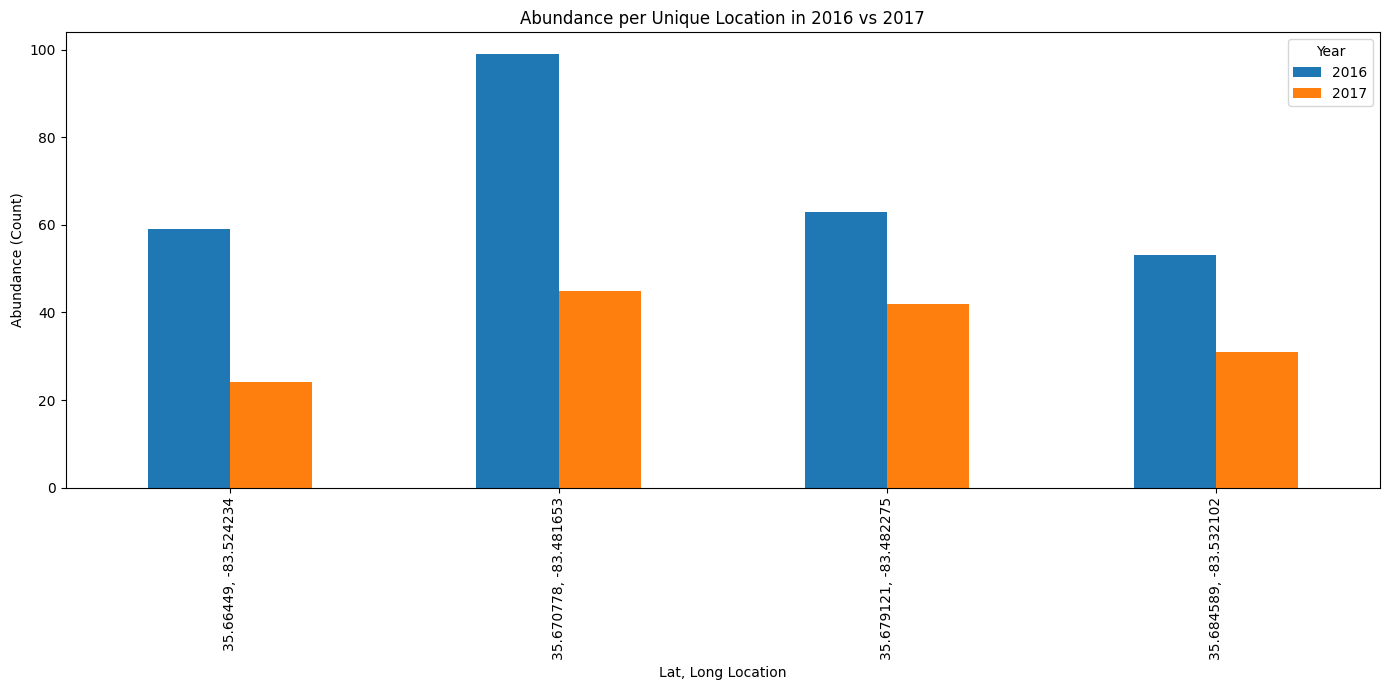

In [43]:
import matplotlib.pyplot as plt

# Load the GBIF records from your GeoJSON file
gdf = gpd.read_file("gbif_carabids_gsmnp_2016_2017.geojson")

# Create a new column that identifies each unique location by combining latitude and longitude as a string.
# Adjust formatting as needed.
gdf['location'] = gdf['latitude'].astype(str) + ", " + gdf['longitude'].astype(str)

# Group by year and location, counting the number of occurrences (abundance) per location for each year.
abundance_by_loc = gdf.groupby(['year', 'location']).size().reset_index(name='count')

# Pivot the grouped DataFrame so that each unique location is a row and the columns are the counts for each year.
pivot_abundance = abundance_by_loc.pivot(index='location', columns='year', values='count').fillna(0)

# For clarity, sort the locations (this step is optional and dependent on your preference)
pivot_abundance = pivot_abundance.sort_index()

# Plot a grouped bar chart (histogram style) with unique locations on the x-axis and counts as bar heights.
ax = pivot_abundance.plot(kind='bar', figsize=(14, 7))

ax.set_xlabel("Lat, Long Location")
ax.set_ylabel("Abundance (Count)")
ax.set_title("Abundance per Unique Location in 2016 vs 2017")
ax.legend(title="Year")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability

plt.tight_layout()
plt.show()




#### Compare species from year to year

                    species   latitude  longitude  year       eventID  \
0   Cyclotrachelus freitagi  35.664490 -83.524234  2016  GRSM.2016.18   
1     Pterostichus acutipes  35.679121 -83.482275  2016  GRSM.2016.18   
2  Gastrellarius blanchardi  35.664490 -83.524234  2016  GRSM.2016.18   
3             Tachys laevus  35.664490 -83.524234  2016  GRSM.2016.18   
4  Sphaeroderus bicarinatus  35.670778 -83.481653  2016  GRSM.2016.18   

                     geometry  
0  POINT (-83.52423 35.66449)  
1  POINT (-83.48228 35.67912)  
2  POINT (-83.52423 35.66449)  
3  POINT (-83.52423 35.66449)  
4  POINT (-83.48165 35.67078)  
year                       2016  2017
species                              
Amphasia interstitialis       0     3
Anillinus langdoni            0     2
Aulacopodus brouni            1     0
Carabus goryi                43    53
Cyclotrachelus freitagi      17     5
Cyclotrachelus sigillatus    32     2
Cylindera unipunctata         2     1
Dicaelus dilatatus         

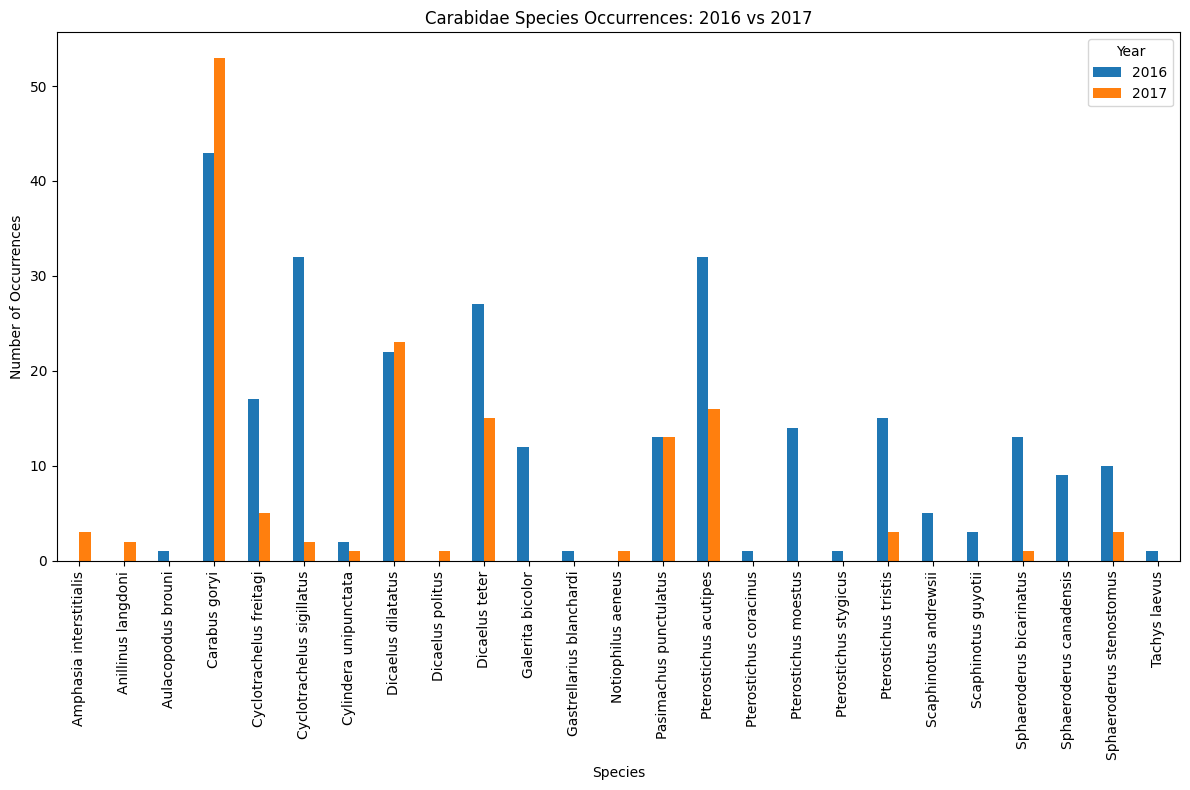

In [44]:
# Load the GBIF records from your GeoJSON file
gbif_geojson = "gbif_carabids_gsmnp_2016_2017.geojson"
gdf = gpd.read_file(gbif_geojson)

# Preview the data to ensure species and year fields are present
print(gdf.head())

# Group the data by species and year, and count the number of occurrences per group
# This creates a DataFrame with species as index and each year as a column.
species_counts = gdf.groupby(["species", "year"]).size().unstack(fill_value=0)

# Display the DataFrame to verify the counts (optional)
print(species_counts)

# Plotting the counts in a grouped bar chart
ax = species_counts.plot(kind='bar', figsize=(12, 8))

# Add labels and title
ax.set_xlabel("Species")
ax.set_ylabel("Number of Occurrences")
ax.set_title("Carabidae Species Occurrences: 2016 vs 2017")
ax.legend(title="Year")

plt.tight_layout()
plt.show()


#### NBR values as a proxy for burn severity compared to trap areas